In [2]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB7
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [3]:
import shutil
shutil.rmtree('/kaggle/working/')

OSError: [Errno 16] Device or resource busy: '/kaggle/working/'

In [4]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = '/kaggle/input/new-plant-diseases-dataset/test'
diseases = os.listdir(train_dir)

In [5]:
# printing the disease names
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [6]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [7]:
#extract the number of unique plants and number of unique diseases
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [9]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [10]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


In [11]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


In [12]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


#  Preprocessing 

In [13]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)


train_frames_datagen = ImageDataGenerator(**data_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
 

# Seed defined for aligning images and their masks
seed = 1

In [14]:
batch_size=128
image_size= (256,256)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def TrainAugmentGenerator(train_images_dir, seed=1, batch_size=8, target_size=(256, 256)):
    data_gen_args = dict(rescale=1./255)
    train_frames_datagen = ImageDataGenerator(**data_gen_args)
    
    train_image_generator = train_frames_datagen.flow_from_directory(
        train_images_dir,
        batch_size=batch_size,
        seed=seed,
        class_mode='categorical',
        target_size=target_size
    )
    return train_image_generator
#     while True:
#         X1i = train_image_generator.next()
#         yield X1i[0], X1i[1]  # Assuming X1i[0] is the image and X1i[1] is the label (without masks)

def ValAugmentGenerator(val_images_dir, seed=1, batch_size=8, target_size=(256, 256)):
    data_gen_args = dict(rescale=1./255)
    val_frames_datagen = ImageDataGenerator(**data_gen_args)

    val_image_generator = val_frames_datagen.flow_from_directory(
        val_images_dir,
        batch_size=batch_size,
        seed=seed,
        class_mode='categorical',
        target_size=target_size
    )
    return val_image_generator
#     while True:
#         X1i = val_image_generator.next()
#         yield X1i[0], X1i[1]  # Assuming X1i[0] is the image and X1i[1] is the label (without masks)


In [16]:
next(TrainAugmentGenerator(train_dir, seed=1, batch_size=8, target_size=(512, 512)))

Found 70295 images belonging to 38 classes.


(array([[[[0.41960788, 0.34901962, 0.41176474],
          [0.41960788, 0.34901962, 0.41176474],
          [0.427451  , 0.35686275, 0.41960788],
          ...,
          [0.46274513, 0.39607847, 0.45882356],
          [0.47058827, 0.4039216 , 0.4666667 ],
          [0.47058827, 0.4039216 , 0.4666667 ]],
 
         [[0.41960788, 0.34901962, 0.41176474],
          [0.41960788, 0.34901962, 0.41176474],
          [0.427451  , 0.35686275, 0.41960788],
          ...,
          [0.46274513, 0.39607847, 0.45882356],
          [0.47058827, 0.4039216 , 0.4666667 ],
          [0.47058827, 0.4039216 , 0.4666667 ]],
 
         [[0.4156863 , 0.34509805, 0.40784317],
          [0.4156863 , 0.34509805, 0.40784317],
          [0.4156863 , 0.34509805, 0.40784317],
          ...,
          [0.4666667 , 0.40000004, 0.46274513],
          [0.4784314 , 0.41176474, 0.47450984],
          [0.4784314 , 0.41176474, 0.47450984]],
 
         ...,
 
         [[0.45098042, 0.3803922 , 0.427451  ],
          [0.45098

In [18]:
next(ValAugmentGenerator(valid_dir, seed=1, batch_size=8, target_size=(512, 512)))

Found 17572 images belonging to 38 classes.


(array([[[[0.04313726, 0.01960784, 0.03529412],
          [0.04313726, 0.01960784, 0.03529412],
          [0.01568628, 0.        , 0.00784314],
          ...,
          [0.03137255, 0.        , 0.        ],
          [0.04705883, 0.        , 0.00784314],
          [0.04705883, 0.        , 0.00784314]],
 
         [[0.04313726, 0.01960784, 0.03529412],
          [0.04313726, 0.01960784, 0.03529412],
          [0.01568628, 0.        , 0.00784314],
          ...,
          [0.03137255, 0.        , 0.        ],
          [0.04705883, 0.        , 0.00784314],
          [0.04705883, 0.        , 0.00784314]],
 
         [[0.70980394, 0.6862745 , 0.7019608 ],
          [0.70980394, 0.6862745 , 0.7019608 ],
          [0.68235296, 0.65882355, 0.6745098 ],
          ...,
          [0.5686275 , 0.52156866, 0.5294118 ],
          [0.6039216 , 0.5568628 , 0.5647059 ],
          [0.6039216 , 0.5568628 , 0.5647059 ]],
 
         ...,
 
         [[0.69803923, 0.654902  , 0.6784314 ],
          [0.69803

In [19]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(256, 256, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 38, activation = 'softmax'))

In [20]:
batch_size = 64
#num_train_samples = len(np.sort(os.listdir(train_dir)))
#num_val_samples = len(np.sort(os.listdir(valid_dir)))
num_train_samples = 70295
num_val_samples = 17572
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  1099.0
validation_steps:  1099.0


In [21]:
from tensorflow.keras import backend as K


K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

classifier.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
#model.summary()

In [22]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

# LearningRateScheduler:- decreases learning rate at every epoch 
checkpoint = ModelCheckpoint(
    filepath = 'Model.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [ ]:
history = classifier.fit(
    TrainAugmentGenerator(train_dir, batch_size=batch_size, target_size=image_size),
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=ValAugmentGenerator(valid_dir, batch_size=batch_size, target_size=image_size),
    validation_steps=validation_steps,
    callbacks=callbacks,
    use_multiprocessing=False,  # Set to True if using CPU parallelism
    verbose=1
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
1099/1099 [==============================] - ETA: 0s - loss: 1.4837 - dice_coef: 0.4846 - accuracy: 0.5724
Epoch 00001: val_loss improved from inf to 0.98495, saving model to Model.h5
1099/1099 [==============================] - 805s 733ms/step - loss: 1.4837 - dice_coef: 0.4846 - accuracy: 0.5724 - val_loss: 0.9849 - val_dice_coef: 0.6575 - val_accuracy: 0.7116

Epoch 00002: LearningRateScheduler reducing learning rate to 9.623506263980886e-05.
Epoch 2/10
 901/1099 [=======================>......] - ETA: 53s - loss: 0.5976 - dice_coef: 0.7440 - accuracy: 0.8110

In [24]:
classifier.load_weights("/kaggle/working/Model.h5")

In [25]:
import os


class_labels = os.listdir(train_dir)
print("Class Labels:", class_labels)

Class Labels: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mo

In [26]:
# Create a dictionary mapping class labels to indices
class_dict= {label: index for index, label in enumerate(class_labels)}

print("Class Labels to Index:", class_dict)

Class Labels to Index: {'Tomato___Late_blight': 0, 'Tomato___healthy': 1, 'Grape___healthy': 2, 'Orange___Haunglongbing_(Citrus_greening)': 3, 'Soybean___healthy': 4, 'Squash___Powdery_mildew': 5, 'Potato___healthy': 6, 'Corn_(maize)___Northern_Leaf_Blight': 7, 'Tomato___Early_blight': 8, 'Tomato___Septoria_leaf_spot': 9, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 10, 'Strawberry___Leaf_scorch': 11, 'Peach___healthy': 12, 'Apple___Apple_scab': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Black_rot': 16, 'Blueberry___healthy': 17, 'Cherry_(including_sour)___Powdery_mildew': 18, 'Peach___Bacterial_spot': 19, 'Apple___Cedar_apple_rust': 20, 'Tomato___Target_Spot': 21, 'Pepper,_bell___healthy': 22, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 23, 'Potato___Late_blight': 24, 'Tomato___Tomato_mosaic_virus': 25, 'Strawberry___healthy': 26, 'Apple___healthy': 27, 'Grape___Black_rot': 28, 'Potato___Early_blight': 29, 'Cherry_(including_so

In [27]:
li = list(class_dict.keys())
print(li)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

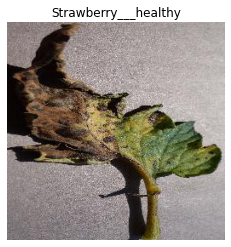

Following is our prediction: Strawberry___healthy


In [28]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path, class_labels):
    # Load and preprocess the image
    new_img = image.load_img(image_path, target_size=(256, 256))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    # Perform prediction
    prediction = model.predict(img)

    # Get the predicted class
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    # Plot the image with the predicted class name
    plt.figure(figsize=(4, 4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(predicted_class)
    plt.show()

    return predicted_class


predicted_class = predict_image(classifier, "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG", class_labels)
print("Following is our prediction:", predicted_class)